# Description
- Import the data
- Generate simple strain plots

## Import Packages

In [1]:
# For calculating derivatives and integrals
import math
import pynumdiff
import scipy

# For processing data
import numpy as np
import pandas as pd
import cvxpy as cp

# For calculating frequency content
from scipy import fft
from scipy import signal

# For plotting signals
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

2023-07-26 11:45:54,712 [INFO] 
Limited Linear Model Support Detected! 
---> PYCHEBFUN is not installed. 
---> Install pychebfun to use chebfun derivatives (https://github.com/pychebfun/pychebfun/) 
You can still use other methods 

2023-07-26 11:45:54,790 [INFO] Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2023-07-26 11:45:54,791 [INFO] NumExpr defaulting to 8 threads.


In [130]:
import figurefirst as fifi

# Functions

In [2]:
# Perform a mean subtraction to ensure data is centered around the zero.
def sig_mean_df(df, columns,time):
    df_mean = pd.DataFrame(columns=columns)
    for i in range(len(columns)):
        signal = df[columns[i]]
        signal_mean = np.mean(signal)
        signal_use = (signal-signal_mean)
        df_mean[columns[i]] = signal_use
    df_mean[time] = df[time]
    
    return(df_mean)

# Smooth your data like butter. Return original dataframe with smoothed data appended.
def smooth_butter(df, params, dt, col_names):
    for i in range(np.size(col_names)):
        df[col_names[i] + '_hat'], df[col_names[i] + '_dt'] = pynumdiff.smooth_finite_difference.butterdiff(df[col_names[i]], dt, params, options={'iterate': False})
    return(df)

# Smooth your data and return only smooth signals.
def smooth_only(df, params, dt, col_names):
    df_new = pd.DataFrame()
    for i in range(len(col_names)):
        smooth_data, smooth_derivative = pynumdiff.smooth_finite_difference.butterdiff(df[col_names[i]], dt, params, options={'iterate': False})
        df_new[col_names[i]] = smooth_data 
    return(df_new)

# Calculate the DFT of a data set and return a data frame including the DFT data
def simple_fft_array(array,dt):
    fft_df = pd.DataFrame()
    N = np.shape(array)[0]
    yf = 2.0/N * np.abs(fft.fft(array)[0:N//2])
    xf = fft.fftfreq(N,dt)[:N//2]
    fft_df['array_fft'] = yf
    fft_df['frequency'] = xf
    return(fft_df)

# Take the FFT of a dataset and return a new data frame containing the DFT data.
def fft_of_data_df(df,dt,columns):
    fft_df = pd.DataFrame()
    for i in range(len(columns)):
        data = df[columns[i]]
        data = np.array(data)
        N = data.shape[0] # Length of data.
        yf = 2.0/N * np.abs(fft.fft(data)[0:N//2])# Divide to bring the manitude to the magnitude of the orginal sinewave.
        # Remember the the y-data will be complex so you have to take the absolute value.
        xf = fft.fftfreq(N,dt)[:N//2]# Only take the first half of the data.
        fft_df[columns[i]+'_fft'] = yf
        if i == len(columns)-1:
            fft_df['Frequency'] = xf
    return(fft_df)

# Use query to extract segments of data.
def segment_data(df, column_title, lower_lim, upper_lim):
    q = column_title + ' < ' + str(upper_lim) + ' and ' + column_title + ' > ' + str(lower_lim)
    new_df = df.query(q)
    return(new_df)

# Segment the data into desired segment size and take the FFT of the signals
# Return a new data frame.
def segment_create_new_df_for_each_sg(list_of_dfs,strain_gauge,chunck_size,snow_types,dt):
    lower_freq = 1/60
    high_freq = 150
    df_new = pd.DataFrame()
#     dataframes = np.shape(list_of_dfs[0])[0]
    data_frames = len(snow_types)-1
    for j in range(data_frames):
            df_column = list_of_dfs[j][strain_gauge]
            n = len(df_column)//chunk_size
            for i in range(n):
                data = df_column[i*chunk_size:(i+1)*chunk_size] # "data" is the segmented timeseries. 
                df_new[df_column.name+'_'+str(i+1)+'_'+snow_types[j]] = data.reset_index(drop=True)
    df_new = fft_of_data_df(df_new,dt,df_new.columns.tolist())
    # Take every 5th entry.
    df_new = segment_data(df_new,'Frequency',lower_freq,high_freq) #.iloc[0::2,:].reset_index(drop=True)
    return(df_new)

## Code

## 1.0 Load data and format data

In [3]:
# Import ski data
df_grmr = pd.read_hdf('DATA/df_grmr.hdf')
df_grmr1 = pd.read_hdf('DATA/df_grmr1.hdf')
df_grmr2 = pd.read_hdf('DATA/df_grmr2.hdf')
df_grmr3 = pd.read_hdf('DATA/df_grmr3.hdf')
df_grmr4 = pd.read_hdf('DATA/df_grmr4.hdf')
df_grmr5 = pd.read_hdf('DATA/df_grmr5.hdf')

df_pwdr = pd.read_hdf('DATA/df_pwdr.hdf')
df_pwdr1 = pd.read_hdf('DATA/df_pwdr1.hdf')

df_icy = pd.read_hdf('DATA/df_icy.hdf')

df_s = pd.read_hdf('DATA/df_s.hdf')
df_s1 = pd.read_hdf('DATA/df_s1.hdf')
df_s2 = pd.read_hdf('DATA/df_s2.hdf')
df_s3 = pd.read_hdf('DATA/df_s3.hdf')

In [4]:
# Create data frames that are mean subtracted.
columns = ['sg3','sg4','sg6','sgc','sg7','sg12','sg15','imu_ax','imu_ay','imu_az','imu_wx','imu_wy','imu_wz'] # Columns to use.
df_grmr_mean  = sig_mean_df(df_grmr,columns,'time_imu')
df_grmr1_mean = sig_mean_df(df_grmr1,columns,'time_imu')
df_grmr2_mean = sig_mean_df(df_grmr2,columns,'time_imu')
df_grmr3_mean = sig_mean_df(df_grmr3,columns,'time_imu')
df_grmr4_mean = sig_mean_df(df_grmr4,columns,'time_imu')
df_grmr5_mean = sig_mean_df(df_grmr5,columns,'time_imu')
df_pwdr_mean  = sig_mean_df(df_pwdr,columns,'time_imu')
df_pwdr1_mean = sig_mean_df(df_pwdr1,columns,'time_imu')
df_icy_mean   = sig_mean_df(df_icy,columns,'time_imu')
df_s_mean     = sig_mean_df(df_s,columns,'time_imu')
df_s1_mean    = sig_mean_df(df_s1,columns,'time_imu')
df_s2_mean    = sig_mean_df(df_s2,columns,'time_imu')
df_s3_mean    = sig_mean_df(df_s3,columns,'time_imu')
all_mean_time = [df_grmr_mean,df_grmr1_mean,df_grmr2_mean,df_grmr3_mean,df_grmr4_mean,df_grmr5_mean,
                df_pwdr_mean,df_pwdr1_mean,
                df_icy_mean,
                df_s_mean,df_s1_mean,df_s2_mean,df_s3_mean]

## 1.1 Plot strain and smoothed angular velocity data

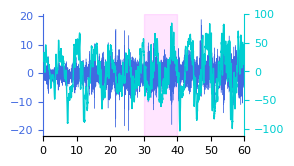

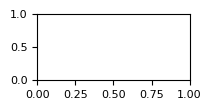

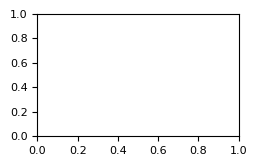

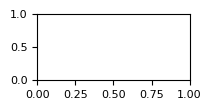

In [100]:
import figurefirst as fifi

layout = fifi.svg_to_axes.FigureLayout('Fig8_full_run_2turn_new.svg', 
                                       autogenlayers=True, make_mplfigures=True, hide_layers=[])
ax = layout.axes[('skirun', 'skirun')]


# Simple Plots
ski_run = 1
width = 6
height = 3
color1 = 'royalblue'
color2 = 'darkturquoise'
xlim = [0,60]
xlim_zoom = [30, 40]

mpl.rc('font', size=8)
# fig.subplots_adjust(hspace=0.2)
ax1 = ax.twinx()

t0 = df_grmr1.time_imu.min()
ax.plot(df_grmr1.time_imu-t0,df_grmr1_mean.sg7, '-', color=color1, linewidth=0.3, label='Strain')
ax1.plot(df_grmr1.time_imu-t0,df_grmr1.imu_wz, '-', color=color2, linewidth=1, label='Ang. vel.')
ax.axvspan(xlim_zoom[0], xlim_zoom[1], color='magenta', alpha=.1, zorder=-1)

# Uncomment this to create a zoomed in plot consisting of two turns.
ax.set_xlim(xlim)
ax1.set_xlim(xlim)

ax.tick_params(axis='y', colors=color1)
ax.spines['left'].set_color(color1)  
ax1.tick_params(axis='y', colors=color2)
ax1.spines['right'].set_color(color2)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
#plt.savefig("full_run_angvel_strain_2turns.svg",bbox_inches='tight',dpi=fig.dpi)

ax1.set_yticks([-100, -50, 0, 50, 100])
ax.set_yticks([-20, -10, 0, 10, 20])
fifi.mpl_functions.set_fontsize(ax, 8)

layout.append_figure_to_layer(layout.figures['skirun'], 'skirun', cleartarget=True)
layout.write_svg('Fig8_full_run_2turn_new.svg')

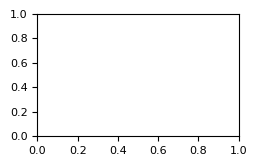

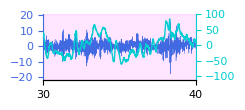

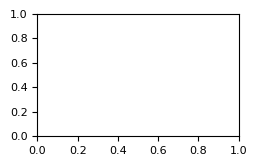

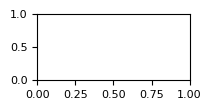

In [102]:
import figurefirst as fifi

layout = fifi.svg_to_axes.FigureLayout('Fig8_full_run_2turn_new.svg', 
                                       autogenlayers=True, make_mplfigures=True, hide_layers=[])
ax = layout.axes[('skiturn', 'skiturn')]


# Simple Plots
ski_run = 1
width = 6
height = 3
color1 = 'royalblue'
color2 = 'darkturquoise'
xlim = [0,60]
xlim_zoom = [30, 40]

mpl.rc('font', size=8)
# fig.subplots_adjust(hspace=0.2)
ax1 = ax.twinx()

t0 = df_grmr1.time_imu.min()
ax.plot(df_grmr1.time_imu-t0,df_grmr1_mean.sg7, '-', color=color1, linewidth=0.3, label='Strain')
ax1.plot(df_grmr1.time_imu-t0,df_grmr1.imu_wz, '-', color=color2, linewidth=1, label='Ang. vel.')
ax.axvspan(xlim_zoom[0], xlim_zoom[1], color='magenta', alpha=.1, zorder=-1)

# Uncomment this to create a zoomed in plot consisting of two turns.
ax.set_xlim(xlim_zoom)
ax1.set_xlim(xlim_zoom)

ax.tick_params(axis='y', colors=color1)
ax.spines['left'].set_color(color1)  
ax1.tick_params(axis='y', colors=color2)
ax1.spines['right'].set_color(color2)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
#plt.savefig("full_run_angvel_strain_2turns.svg",bbox_inches='tight',dpi=fig.dpi)

ax1.set_yticks([-100, -50, 0, 50, 100])
ax.set_yticks([-20, -10, 0, 10, 20])
ax.set_xticks([30, 40])
fifi.mpl_functions.set_fontsize(ax, 8)

layout.append_figure_to_layer(layout.figures['skiturn'], 'skiturn', cleartarget=True)
layout.write_svg('Fig8_full_run_2turn_new.svg')

## 1.1 Plot strain and smoothed angular velocity data: POWDER

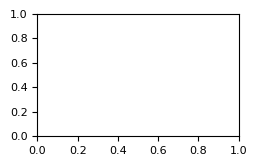

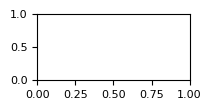

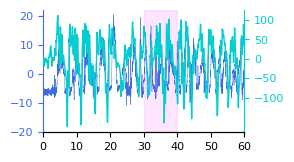

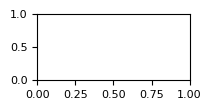

In [97]:
import figurefirst as fifi

layout = fifi.svg_to_axes.FigureLayout('Fig8_full_run_2turn_new.svg', 
                                       autogenlayers=True, make_mplfigures=True, hide_layers=[])
ax = layout.axes[('skirunpow', 'skirunpow')]


# Simple Plots
ski_run = 1
width = 6
height = 3
color1 = 'royalblue'
color2 = 'darkturquoise'
xlim = [0, 60]
xlim_zoom = [30, 40]

mpl.rc('font', size=8)
# fig.subplots_adjust(hspace=0.2)
ax1 = ax.twinx()

t0 = df_pwdr.time_imu.min()
ax.plot(df_pwdr.time_imu-t0,df_pwdr_mean.sg7, '-', color=color1, linewidth=0.3, label='Strain')
ax1.plot(df_pwdr.time_imu-t0,df_pwdr.imu_wz, '-', color=color2, linewidth=1, label='Ang. vel.')
ax.axvspan(xlim_zoom[0], xlim_zoom[1], color='magenta', alpha=.1, zorder=-1)

# Uncomment this to create a zoomed in plot consisting of two turns.
ax.set_xlim(xlim)
ax1.set_xlim(xlim)

ax.tick_params(axis='y', colors=color1)
ax.spines['left'].set_color(color1)  
ax1.tick_params(axis='y', colors=color2)
ax1.spines['right'].set_color(color2)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
#plt.savefig("full_run_angvel_strain_2turns.svg",bbox_inches='tight',dpi=fig.dpi)

ax1.set_yticks([-100, -50, 0, 50, 100])
ax.set_yticks([-20, -10, 0, 10, 20])
fifi.mpl_functions.set_fontsize(ax, 8)

layout.append_figure_to_layer(layout.figures['skirunpow'], 'skirunpow', cleartarget=True)
layout.write_svg('Fig8_full_run_2turn_new.svg')

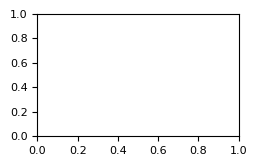

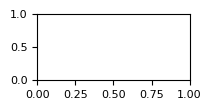

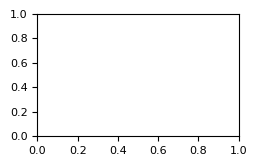

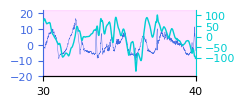

In [96]:
import figurefirst as fifi

layout = fifi.svg_to_axes.FigureLayout('Fig8_full_run_2turn_new.svg', 
                                       autogenlayers=True, make_mplfigures=True, hide_layers=[])
ax = layout.axes[('skiturnpow', 'skiturnpow')]


# Simple Plots
ski_run = 1
width = 6
height = 3
color1 = 'royalblue'
color2 = 'darkturquoise'
xlim = [30, 40]
xlim_zoom = [30, 40]

mpl.rc('font', size=8)
# fig.subplots_adjust(hspace=0.2)
ax1 = ax.twinx()

t0 = df_pwdr.time_imu.min()
ax.plot(df_pwdr.time_imu-t0,df_pwdr_mean.sg7, '-', color=color1, linewidth=0.3, label='Strain')
ax1.plot(df_pwdr.time_imu-t0,df_pwdr.imu_wz, '-', color=color2, linewidth=1, label='Ang. vel.')
ax.axvspan(xlim_zoom[0], xlim_zoom[1], color='magenta', alpha=.1, zorder=-1)

# Uncomment this to create a zoomed in plot consisting of two turns.
ax.set_xlim(xlim)
ax1.set_xlim(xlim)

ax.tick_params(axis='y', colors=color1)
ax.spines['left'].set_color(color1)  
ax1.tick_params(axis='y', colors=color2)
ax1.spines['right'].set_color(color2)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
#plt.savefig("full_run_angvel_strain_2turns.svg",bbox_inches='tight',dpi=fig.dpi)

ax1.set_yticks([-100, -50, 0, 50, 100])
ax.set_yticks([-20, -10, 0, 10, 20])
ax.set_xticks([30, 40])
fifi.mpl_functions.set_fontsize(ax, 8)

layout.append_figure_to_layer(layout.figures['skiturnpow'], 'skiturnpow', cleartarget=True)
layout.write_svg('Fig8_full_run_2turn_new.svg')

## 1.2 Segment the data into two turn segments

In [6]:
# Segment the original non normalized strain data.
# And take the FFT of the signals.
dt = 0.001 # Sample period
snow_types = ['groomer_slow','groomer_slow1','groomer_fast','groomer_fast1','groomer_slow2','groomer_fast2','powder_1',
              'powder_5','icy_fast','icy1_fast','slushy_fast','slushy_slow','slushy_fast1','slushy_slow1']
strain_gauge = ['sg3','sg4','sg12','sg6','sgc','sg7','sg15']
chunk_size = 10000
sg3_segmented_all_snow = segment_create_new_df_for_each_sg(all_mean_time,strain_gauge[0],chunk_size,snow_types,dt)
sg4_segmented_all_snow = segment_create_new_df_for_each_sg(all_mean_time,strain_gauge[1],chunk_size,snow_types,dt)
sg12_segmented_all_snow = segment_create_new_df_for_each_sg(all_mean_time,strain_gauge[2],chunk_size,snow_types,dt)
sg6_segmented_all_snow = segment_create_new_df_for_each_sg(all_mean_time,strain_gauge[3],chunk_size,snow_types,dt)
sgc_segmented_all_snow = segment_create_new_df_for_each_sg(all_mean_time,strain_gauge[4],chunk_size,snow_types,dt)
sg7_segmented_all_snow = segment_create_new_df_for_each_sg(all_mean_time,strain_gauge[5],chunk_size,snow_types,dt)
sg15_segmented_all_snow = segment_create_new_df_for_each_sg(all_mean_time,strain_gauge[6],chunk_size,snow_types,dt)

strain_segmented_all_fft = [sg3_segmented_all_snow.iloc[:,0:65],sg12_segmented_all_snow.iloc[:,0:65],sg6_segmented_all_snow.iloc[:,0:65],
                           sgc_segmented_all_snow.iloc[:,0:65],sg7_segmented_all_snow.iloc[:,0:65],sg15_segmented_all_snow.iloc[:,0:65]]

ang_velx_all_snow = segment_create_new_df_for_each_sg(all_mean_time,'imu_wx',chunk_size,snow_types,dt)
ang_vely_all_snow = segment_create_new_df_for_each_sg(all_mean_time,'imu_wy',chunk_size,snow_types,dt)
ang_velz_all_snow = segment_create_new_df_for_each_sg(all_mean_time,'imu_wz',chunk_size,snow_types,dt)

angular_vel_all = [ang_velx_all_snow,ang_vely_all_snow,ang_velz_all_snow]

In [149]:
len(snow_types)

14

## 1.3 Solve the CVX bode plot

In [7]:
# Calculate the DFT ratio for x axis
gamma = 0.8 # Weighting parameter for total variance constraint.
# Z axis
all_b3 = []
all_b12 = []
all_b6 = []
all_bc = []
all_b7 = []
all_b15 = []

for i in range(np.shape(ang_velz_all_snow)[1]-1):
    in_data = np.array(ang_velz_all_snow.iloc[:,i]).reshape((np.shape(ang_velz_all_snow.iloc[:,i])[0],1)) # The input will be the same across all strain gauges.
    out_data3 = np.array(sg3_segmented_all_snow.iloc[:,i]).reshape((np.shape(sg3_segmented_all_snow.iloc[:,i])[0],1))
    out_data12 = np.array(sg12_segmented_all_snow.iloc[:,i]).reshape((np.shape(sg12_segmented_all_snow.iloc[:,i])[0],1))
    out_data6 = np.array(sg6_segmented_all_snow.iloc[:,i]).reshape((np.shape(sg6_segmented_all_snow.iloc[:,i])[0],1))
    out_datac = np.array(sgc_segmented_all_snow.iloc[:,i]).reshape((np.shape(sgc_segmented_all_snow.iloc[:,i])[0],1))
    out_data7 = np.array(sg7_segmented_all_snow.iloc[:,i]).reshape((np.shape(sg7_segmented_all_snow.iloc[:,i])[0],1))
    out_data15 = np.array(sg15_segmented_all_snow.iloc[:,i]).reshape((np.shape(sg15_segmented_all_snow.iloc[:,i])[0],1))

    bode3 = cp.Variable(np.shape(in_data)[0]) # Numerical bode plot that resets every time, but the values are appended. 
    bode12 = cp.Variable(np.shape(in_data)[0])
    bode6 = cp.Variable(np.shape(in_data)[0])
    bodec = cp.Variable(np.shape(in_data)[0])
    bode7 = cp.Variable(np.shape(in_data)[0])
    bode15 = cp.Variable(np.shape(in_data)[0])

    L = cp.sum(cp.square(cp.multiply(in_data[:,0],bode3) - out_data3[:,0])) + gamma*cp.tv(bode3)
    objective = cp.Minimize(L)
    prob = cp.Problem(objective)
    result = prob.solve()
    all_b3.append(bode3.value)
    
    L = cp.sum(cp.square(cp.multiply(in_data[:,0],bode12) - out_data12[:,0])) + gamma*cp.tv(bode12)
    objective = cp.Minimize(L)
    prob = cp.Problem(objective)
    result = prob.solve()
    all_b12.append(bode12.value)
    
    L = cp.sum(cp.square(cp.multiply(in_data[:,0],bode6) - out_data6[:,0])) + gamma*cp.tv(bode6)
    objective = cp.Minimize(L)
    prob = cp.Problem(objective)
    result = prob.solve()
    all_b6.append(bode6.value)
    
    L = cp.sum(cp.square(cp.multiply(in_data[:,0],bodec) - out_datac[:,0])) + gamma*cp.tv(bodec)
    objective = cp.Minimize(L)
    prob = cp.Problem(objective)
    result = prob.solve()
    all_bc.append(bodec.value)
    
    L = cp.sum(cp.square(cp.multiply(in_data[:,0],bode7) - out_data7[:,0])) + gamma*cp.tv(bode7)
    objective = cp.Minimize(L)
    prob = cp.Problem(objective)
    result = prob.solve()
    all_b7.append(bode7.value)
    
    L = cp.sum(cp.square(cp.multiply(in_data[:,0],bode15) - out_data15[:,0])) + gamma*cp.tv(bode15)
    objective = cp.Minimize(L)
    prob = cp.Problem(objective)
    result = prob.solve()
    all_b15.append(bode15.value)
    
all_bode_dataz = [np.transpose(all_b3),np.transpose(all_b12),np.transpose(all_b6),np.transpose(all_bc),np.transpose(all_b7),np.transpose(all_b15)]

In [8]:
np.shape(all_b7)

(65, 1499)

## 2.0 Smooth the DFT signals

In [9]:
# Perform some smoothing of the DFT signals
col_names = sg7_segmented_all_snow.columns
col_names = col_names.to_list()
col_names_wz = ang_velz_all_snow.columns
col_names_wz = col_names_wz.tolist()
params = [3,0.5]
dt = 0.001
smooth_sg7_2_turn = smooth_only(sg7_segmented_all_snow, params, dt, col_names)
smooth_angvelz_2_turn = smooth_only(ang_velz_all_snow, params, dt, col_names_wz)

In [10]:
smooth_sg7_2_turn.columns

Index(['sg7_1_groomer_slow_fft', 'sg7_2_groomer_slow_fft',
       'sg7_3_groomer_slow_fft', 'sg7_4_groomer_slow_fft',
       'sg7_5_groomer_slow_fft', 'sg7_1_groomer_slow1_fft',
       'sg7_2_groomer_slow1_fft', 'sg7_3_groomer_slow1_fft',
       'sg7_4_groomer_slow1_fft', 'sg7_5_groomer_slow1_fft',
       'sg7_1_groomer_fast_fft', 'sg7_2_groomer_fast_fft',
       'sg7_3_groomer_fast_fft', 'sg7_4_groomer_fast_fft',
       'sg7_5_groomer_fast_fft', 'sg7_1_groomer_fast1_fft',
       'sg7_2_groomer_fast1_fft', 'sg7_3_groomer_fast1_fft',
       'sg7_4_groomer_fast1_fft', 'sg7_5_groomer_fast1_fft',
       'sg7_1_groomer_slow2_fft', 'sg7_2_groomer_slow2_fft',
       'sg7_3_groomer_slow2_fft', 'sg7_4_groomer_slow2_fft',
       'sg7_5_groomer_slow2_fft', 'sg7_1_groomer_fast2_fft',
       'sg7_2_groomer_fast2_fft', 'sg7_3_groomer_fast2_fft',
       'sg7_4_groomer_fast2_fft', 'sg7_5_groomer_fast2_fft',
       'sg7_1_powder_1_fft', 'sg7_2_powder_1_fft', 'sg7_3_powder_1_fft',
       'sg7_4_powder_1

## 2.1 plot the frequency contnent of the strain signals

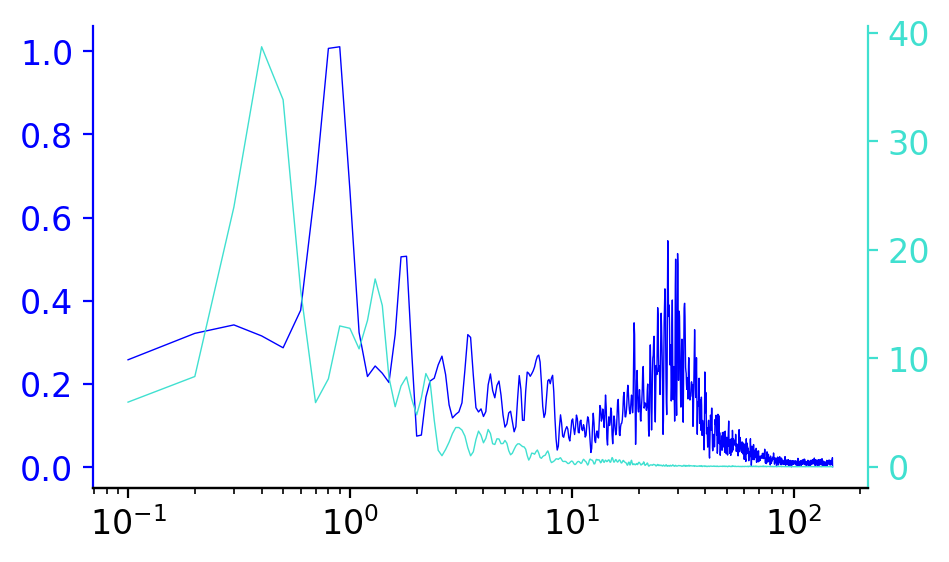

In [177]:
# Frequency content of Groomer snow.
color = 'blue'; color1 = 'turquoise'
mpl.rc('font', size=12)
fig, ax = plt.subplots(1,1,figsize=[5,3], dpi = 200)
fig.subplots_adjust(hspace=0.2)
fig.patch.set_facecolor('white')
ax1 = ax.twinx()
# ax.plot(sg7_segmented_all_snow.Frequency,sg7_segmented_all_snow.sg7_2_groomer_slow_fft, '-', color=color, linewidth=.5, label='Strain')
# ax1.plot(sg7_segmented_all_snow.Frequency,ang_velz_all_snow.imu_wz_2_groomer_slow_fft, '-', color=color1, linewidth=.5, label='Ang. vel.')

ax.plot(sg7_segmented_all_snow.Frequency,smooth_sg7_2_turn.sg7_3_groomer_fast_fft, '-', color=color, linewidth=.5, label='Strain')
ax1.plot(sg7_segmented_all_snow.Frequency,smooth_angvelz_2_turn.imu_wz_3_groomer_fast_fft, '-', color=color1, linewidth=.5, label='Ang. vel.')
#ax.set_title('Groomer')
#ax.set_xlabel('Frequency [Hz]')
#ax.set_ylabel('Back parallel')
#ax1.set_ylabel('Angular velocity z-axis')
ax.set_xscale('log')
ax1.set_xscale('log')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='y', colors=color)  #setting up Y-axis tick color to black
ax.spines['left'].set_color(color) 

ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.tick_params(axis='y', colors=color1)  #setting up Y-axis tick color to black
ax1.spines['right'].set_color(color1) 
plt.savefig("images/groomer_2_turn_fft.svg",bbox_inches='tight',dpi=fig.dpi)
plt.show()

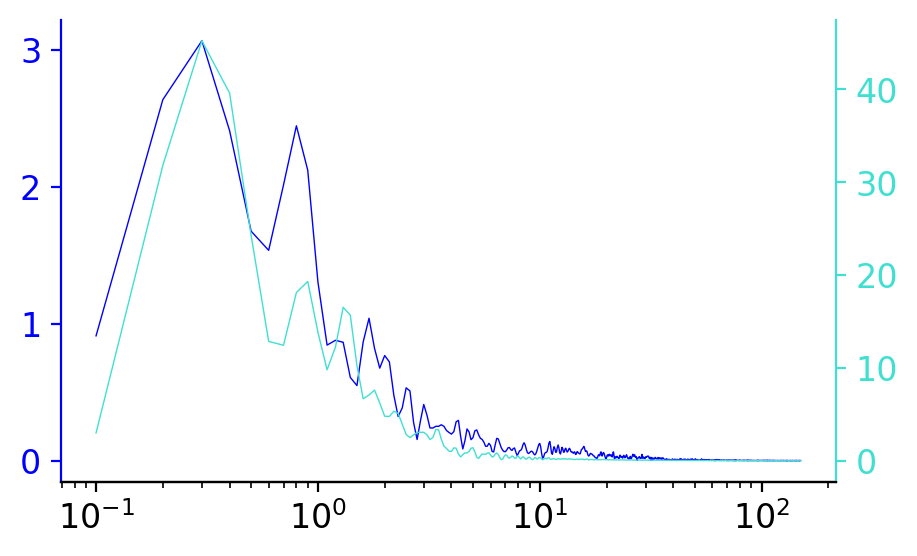

In [153]:
# Simple Plots
color = 'blue'; color1 = 'turquoise'
mpl.rc('font', size=12)
fig, ax = plt.subplots(1,1,figsize=[5,3], dpi = 200)
fig.subplots_adjust(hspace=0.2)
fig.patch.set_facecolor('white')
ax1 = ax.twinx()
# ax.plot(sg7_segmented_all_snow.Frequency,sg7_segmented_all_snow.sg7_2_powder_1_fft, '-', color=color, linewidth=.5, label='Strain')
# ax1.plot(sg7_segmented_all_snow.Frequency,ang_velz_all_snow.imu_wz_2_powder_1_fft, '-', color=color1, linewidth=.5, label='Ang. vel.')

ax.plot(sg7_segmented_all_snow.Frequency,smooth_sg7_2_turn.sg7_2_powder_1_fft, '-', color=color, linewidth=.5, label='Strain')
ax1.plot(sg7_segmented_all_snow.Frequency,smooth_angvelz_2_turn.imu_wz_2_powder_1_fft, '-', color=color1, linewidth=.5, label='Ang. vel.')

#ax.set_title('Powder')
#ax.set_xlabel('Frequency [Hz]')
#ax.set_ylabel('Back parallel')
#ax1.set_ylabel('Angular velocity z-axis')
ax.set_xscale('log')
ax1.set_xscale('log')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='y', colors=color)  #setting up Y-axis tick color to black
ax.spines['left'].set_color(color) 

ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.tick_params(axis='y', colors=color1)  #setting up Y-axis tick color to black
ax1.spines['right'].set_color(color1) 
plt.savefig("images/powder_2_turn_fft.svg",bbox_inches='tight',dpi=fig.dpi)
plt.show()

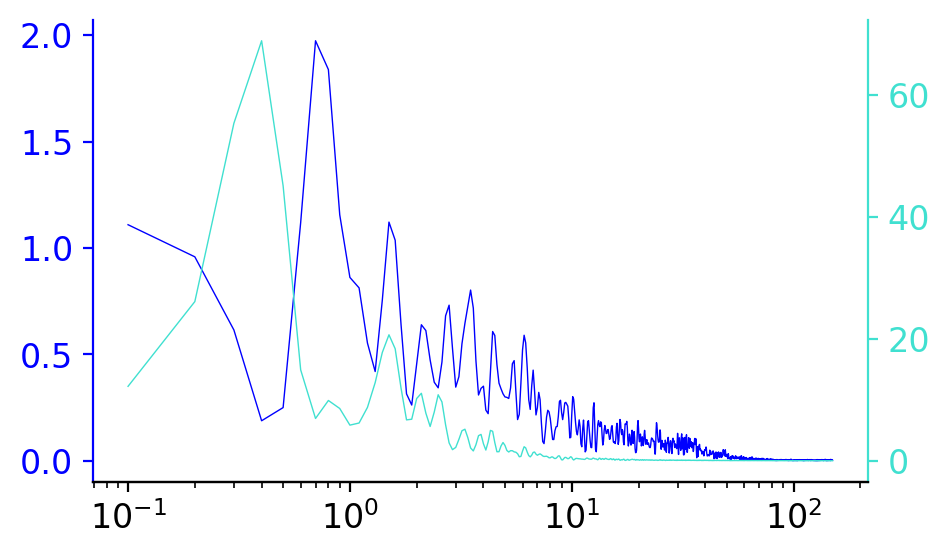

In [154]:
# Simple Plots
color = 'blue'; color1 = 'turquoise'
mpl.rc('font', size=12)
fig, ax = plt.subplots(1,1,figsize=[5,3], dpi = 200)
fig.subplots_adjust(hspace=0.2)
fig.patch.set_facecolor('white')
ax1 = ax.twinx()
# ax.plot(sg7_segmented_all_snow.Frequency,sg7_segmented_all_snow.sg7_2_powder_1_fft, '-', color=color, linewidth=.5, label='Strain')
# ax1.plot(sg7_segmented_all_snow.Frequency,ang_velz_all_snow.imu_wz_2_powder_1_fft, '-', color=color1, linewidth=.5, label='Ang. vel.')

ax.plot(sg7_segmented_all_snow.Frequency,smooth_sg7_2_turn.sg7_4_slushy_slow_fft, '-', color=color, linewidth=.5, label='Strain')
ax1.plot(sg7_segmented_all_snow.Frequency,smooth_angvelz_2_turn.imu_wz_4_slushy_slow_fft, '-', color=color1, linewidth=.5, label='Ang. vel.')

#ax.set_title('Slushy')
#ax.set_xlabel('Frequency [Hz]')
#ax.set_ylabel('Back parallel')
#ax1.set_ylabel('Angular velocity z-axis')
ax.set_xscale('log')
ax1.set_xscale('log')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='y', colors=color)  #setting up Y-axis tick color to black
ax.spines['left'].set_color(color) 

ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.tick_params(axis='y', colors=color1)  #setting up Y-axis tick color to black
ax1.spines['right'].set_color(color1) 
plt.savefig("images/slushy_2_turn_fft.svg",bbox_inches='tight',dpi=fig.dpi)
plt.show()

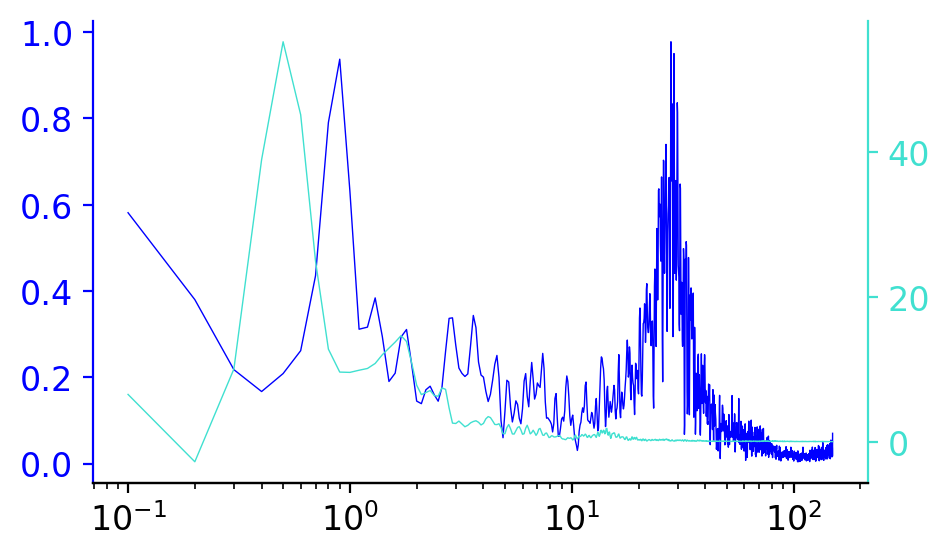

In [155]:
# Simple Plots
color = 'blue'; color1 = 'turquoise'
mpl.rc('font', size=12)
fig, ax = plt.subplots(1,1,figsize=[5,3], dpi = 200)
fig.subplots_adjust(hspace=0.2)
fig.patch.set_facecolor('white')
ax1 = ax.twinx()
# ax.plot(sg7_segmented_all_snow.Frequency,sg7_segmented_all_snow.sg7_2_powder_1_fft, '-', color=color, linewidth=.5, label='Strain')
# ax1.plot(sg7_segmented_all_snow.Frequency,ang_velz_all_snow.imu_wz_2_powder_1_fft, '-', color=color1, linewidth=.5, label='Ang. vel.')

ax.plot(sg7_segmented_all_snow.Frequency,smooth_sg7_2_turn.sg7_4_icy_fast_fft, '-', color=color, linewidth=.5, label='Strain')
ax1.plot(sg7_segmented_all_snow.Frequency,smooth_angvelz_2_turn.imu_wz_4_icy_fast_fft, '-', color=color1, linewidth=.5, label='Ang. vel.')

#ax.set_title('Icy')
#ax.set_xlabel('Frequency [Hz]')
#ax.set_ylabel('Back parallel')
#ax1.set_ylabel('Angular velocity z-axis')
ax.set_xscale('log')
ax1.set_xscale('log')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='y', colors=color)  #setting up Y-axis tick color to black
ax.spines['left'].set_color(color) 

ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.tick_params(axis='y', colors=color1)  #setting up Y-axis tick color to black
ax1.spines['right'].set_color(color1) 
plt.savefig("images/icy_2_turn_fft.svg",bbox_inches='tight',dpi=fig.dpi)

plt.show()

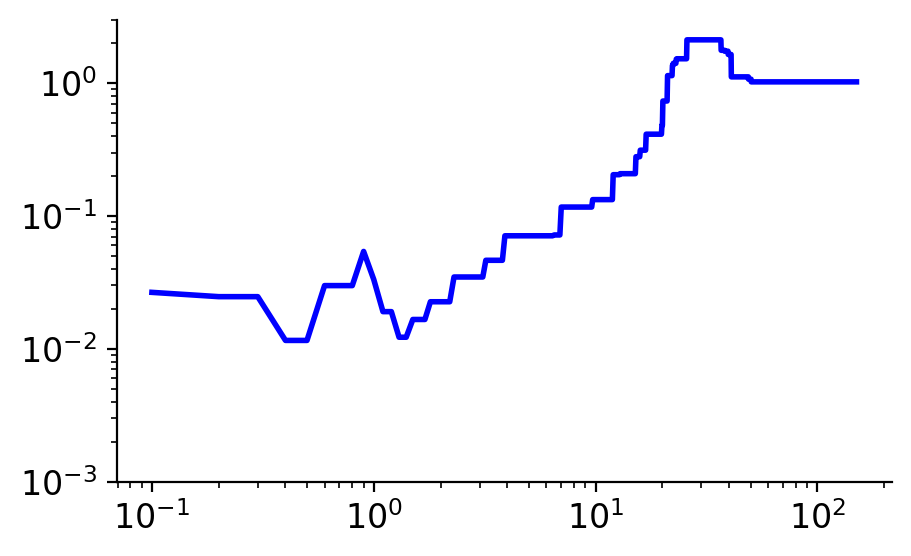

In [178]:
# Frequency content of Groomer snow.
color = 'blue'
mpl.rc('font', size=12)
fig, ax = plt.subplots(1,1,figsize=[5,3], dpi = 200)
fig.subplots_adjust(hspace=0.2)
fig.patch.set_facecolor('white')
ax.plot(sg7_segmented_all_snow.Frequency,all_b7[14], '-', color=color, linewidth=2, label='Strain')

#ax.set_title('Groomer')
#ax.set_xlabel('Frequency [Hz]')
#ax.set_ylabel('Back parallel')
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_ylim(1e-3, 3)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig("images/groomer_2_turn_bode.svg",bbox_inches='tight',dpi=fig.dpi)
plt.show()

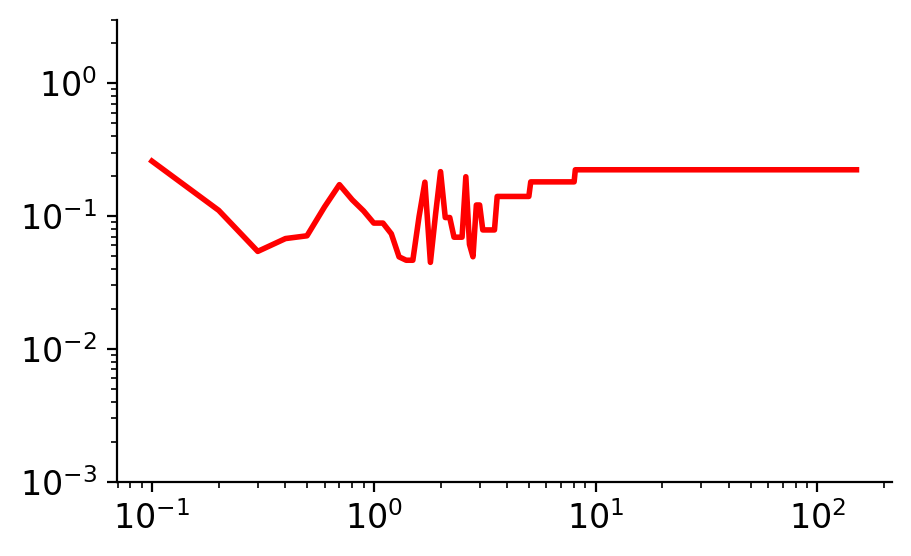

In [179]:
# Frequency content of Groomer snow.
color = 'red'
mpl.rc('font', size=12)
fig, ax = plt.subplots(1,1,figsize=[5,3], dpi = 200)
fig.subplots_adjust(hspace=0.2)
fig.patch.set_facecolor('white')
ax.plot(sg7_segmented_all_snow.Frequency,all_b7[31], '-', color=color, linewidth=2, label='Strain')

#ax.set_title('Powder')
#ax.set_xlabel('Frequency [Hz]')
#ax.set_ylabel('Back parallel')
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_ylim(1e-3, 3)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig("images/powder_2_turn_bode.svg",bbox_inches='tight',dpi=fig.dpi)
plt.show()

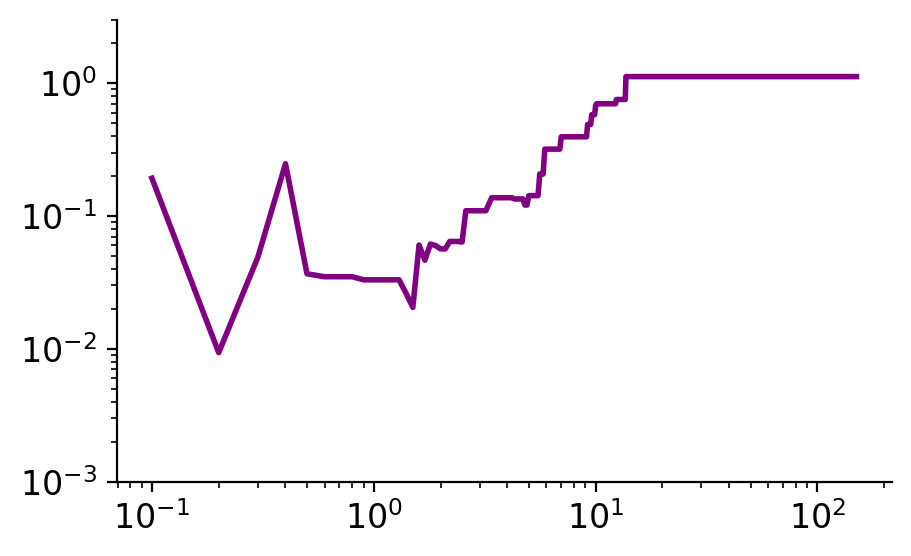

In [180]:
# Frequency content of Groomer snow.
color = 'purple'
mpl.rc('font', size=12)
fig, ax = plt.subplots(1,1,figsize=[5,3], dpi = 200)
fig.subplots_adjust(hspace=0.2)
fig.patch.set_facecolor('white')
ax.plot(sg7_segmented_all_snow.Frequency,all_b7[54], '-', color=color, linewidth=2, label='Strain')

#ax.set_title('Slushy')
#ax.set_xlabel('Frequency [Hz]')
#ax.set_ylabel('Back parallel')
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_ylim(1e-3, 3)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig("images/slushy_2_turn_bode.svg",bbox_inches='tight',dpi=fig.dpi)
plt.show()

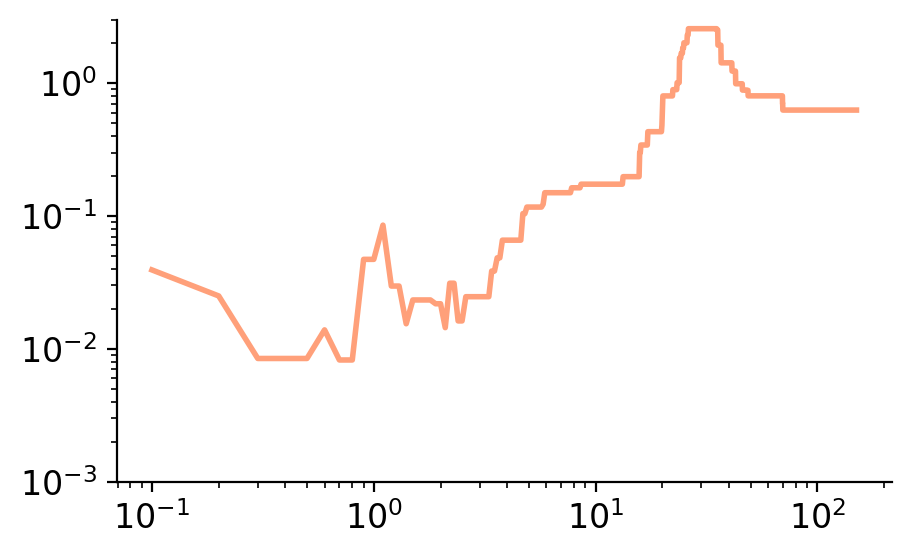

In [181]:
# Frequency content of Groomer snow.
color = 'lightsalmon'
mpl.rc('font', size=12)
fig, ax = plt.subplots(1,1,figsize=[5,3], dpi = 200)
fig.subplots_adjust(hspace=0.2)
fig.patch.set_facecolor('white')
ax.plot(sg7_segmented_all_snow.Frequency,all_b7[44], '-', color=color, linewidth=2, label='Strain')

#ax.set_title('Icy')
#ax.set_xlabel('Frequency [Hz]')
#ax.set_ylabel('Back parallel')
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_ylim(1e-3, 3)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig("images/icy_2_turn_bode.svg",bbox_inches='tight',dpi=fig.dpi)
plt.show()

In [171]:
M = np.array([[2, 1], [0, 1]])

In [174]:
np.linalg.svd(M.T@M)

(array([[-0.85065081, -0.52573111],
        [-0.52573111,  0.85065081]]),
 array([5.23606798, 0.76393202]),
 array([[-0.85065081, -0.52573111],
        [-0.52573111,  0.85065081]]))

In [175]:
np.linalg.eig(M.T@M)

(array([5.23606798, 0.76393202]),
 array([[ 0.85065081, -0.52573111],
        [ 0.52573111,  0.85065081]]))

In [176]:
M.T@M

array([[4, 2],
       [2, 2]])